In [31]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as calc_eigen
from sklearn.model_selection import train_test_split

In [32]:
def extractTrainAndTestData(file_path, r):
    """
    takes images and labels as input
    outputs training data and test data
    """
    mat = scipy.io.loadmat(file_path)
    X_train, X_test, y_train, y_test = train_test_split(mat['X'].T, mat['l'].T, test_size= r, random_state=19)
    N_train = len(X_train[:,0])
    N_test = len(X_test[:,0])
    return X_train, y_train, N_train, X_test, y_test, N_test

def calculateAverageFace(X):
    """
    takes the training data set as input 
    and returns the average face
    """
    average_face= np.mean(X, axis=0)
    #plt.figure()
    #plt.title("Average Face")
    #plt.imshow(np.resize(average_face, (46, 56)).T, cmap='gray')
    return average_face

def normalize(X, AvgFace):
    """
    takes the training data set and average face as input 
    and returns the normalized training data set

    """
    N = len(X[:,0])
    Q = np.empty((N,2576))
    for index, face in enumerate(X):
        Q[index] = face - AvgFace
    return Q.T

def calculateCovarianceMatrix(Q):
    return np.matmul(Q,Q.T)/len(Q[0,:])

def calculateEigenValuesAndVectors(S):
    """
    Takes covariance matrix as input
    and returns eigen values and vectors
    """
    v, w =  calc_eigen.eigh(S)
    #eigen_vectors[:,i] --> eigen_values[i]
    #eigen vector corresponding to eigen value

    #flips left to right... ascending to descending
    v = np.flip(v, axis=0) #turn ascending into descending
    w = np.flip(w, axis=1) #turn ascending into descending
    return v, w

def calculateWeights(Q, U):
    """
    takes input the normalized input and the eigen space
    outputs the weights of the normalized input
    """
    N = len(Q[0,:])
    W = np.empty((N,len(U[0, :])))
    for index, image in enumerate(Q.T):
        W[index] = np.matmul(image, U)
    return W

def calculateWeights2(Q, U):
    """
    alternative method to calculate weights
    """
    N = len(Q[0,:])
    W2 = np.empty((N,len(U[0, :])))
    W2 = np.matmul(Q.T, top_eigen_vectors)
    return W2

def printImage(face, title, saved_file):
    """
    takes input as the face you want to print, the title of the image, and the location of the file
    you would like to save the image to. 
    """
    plt.figure()
    plt.imshow(np.resize(face, (46, 56)).T, cmap='gray')
    plt.title(title)
    plt.savefig(saved_file, bbox_inches='tight')   # save the figure to file
    plt.show()
    plt.close() 
    
def plotEigenValueGraph(v, points):
    """
    plots eigen values against inrementing the number of eigen values used
    in descending order
    """
    y_points = [value for value in v[:points]]
    x_points = [i for i in range(points)]
    plt.xlabel('Number of Eigen Values')
    plt.ylabel('Eigen Values')
    plt.title('Plot of Eigen Values in Descending Order')
    plt.plot(x_points, y_points)
    plt.savefig('eigenvalues.png', bbox_inches='tight')   # save the figure to file
    plt.show()
    plt.close() 

In [33]:
file_path = 'face(1).mat'
M = 300
testRatio = 0.25

X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio)

def calculateEigenSpace(X_train, M):
    AvgFace = calculateAverageFace(X_train)
    A = normalize(X_train, AvgFace)
    S = calculateCovarianceMatrix(A)
    eigen_values, eigen_vectors = calculateEigenValuesAndVectors(S)
    top_eigen_vectors = eigen_vectors[:, :M]
    return AvgFace, A, eigen_values, top_eigen_vectors

AvgFace, A, EigenValues, EigenSpace = calculateEigenSpace(X_train, M)
Weights =  calculateWeights(A, EigenSpace)

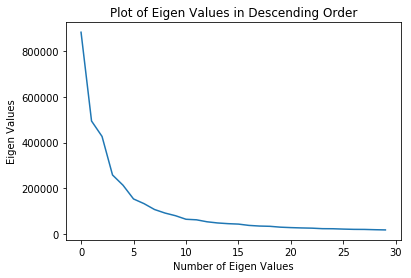

In [34]:
x_points = 30
plotEigenValueGraph(EigenValues, x_points)

In [35]:
np.sum(EigenValues[:390])*100/np.sum(EigenValues)

100.00000000000007

### Reconstruction

In [36]:
def reconstruction(weight, average_face, w):
    return (average_face + np.dot(w, weight.T))

In [37]:
# picking one face and it's corresponding weight for reconstruction
random_index = 5
face_to_be_reconstructed = X_train[random_index, :]
weights_of_face_to_be_reconstructed = Weights[random_index, :]

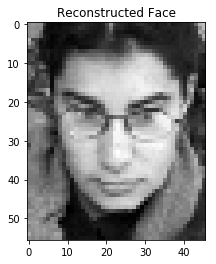

In [38]:
reconstructed_face = reconstruction(weights_of_face_to_be_reconstructed, AvgFace, EigenSpace)
#printImage(face_to_be_reconstructed, "Original Face", "original_face.png")
printImage(reconstructed_face, "Reconstructed Face", "reconstructed_face2.png")

In [39]:
error = reconstructed_face - face_to_be_reconstructed

In [40]:
calc_eigen.norm(error)

69.4995452256011

### Recognition

In [41]:
def NNClassification(r, 
                     y_train, W_train, X_train, 
                     y_test, W_test, X_test):
    
    weight_test = W_test[r, :]
    face_test = X_test[r, :]
    face_test_label = y_test[r, :]
    error = np.empty(( len(W_train[:, 0]) ))
    for index, weight in enumerate(W_train): 
        error[index] = calc_eigen.norm(weight_test - weight)
    min_error = error.min()
    min_error_index = error.argmin()
    face_best_matched = X_train[min_error_index, :]
    label_best_matched = y_train[min_error_index, :]
    #print(face_test_label, '--->', label_best_matched)
    if label_best_matched != face_test_label:
        return 1
    else:
        return 0

In [42]:
A_test = normalize(X_test, AvgFace) #normalize the test data
W_test = calculateWeights(A_test, EigenSpace) #calculate weights of the test data 
totalErrors = 0
for r in range(N_test):
    totalErrors += NNClassification(r, y_train, Weights, X_train, y_test, W_test, X_test)
E_out = totalErrors/N_test
print(E_out*100)

44.61538461538462


In [43]:
len(EigenSpace[0, :])

300

### Alternative Recognition

In [44]:
noOfClasses = 52
reconstrErrors = np.empty((N_test, noOfClasses))
d = {}

for i in range(1, noOfClasses+1): #for each class    
    d["X_train_" + str(i)] = X_train[np.where(y_train == i)[0]]
    N = len(d["X_train_" + str(i)][:,0])
    AvgFace, normalized_Input, EigenValues, topEigenVectors = calculateEigenSpace(d["X_train_" + str(i)], M)
    #weights = calculateWeights(M, normalized_Input, topEigenVectors)
    weight_test = np.matmul(normalize(X_test, AvgFace).T, topEigenVectors)
    for index, weight in enumerate(weight_test):
        reconstructed_face = AvgFace + np.dot(topEigenVectors, weight.T)
        reconstruction_error = calc_eigen.norm(X_test[index] - reconstructed_face)
        reconstrErrors[index, i-1] = reconstruction_error 

In [45]:
total_error = 0
for index, face in enumerate(reconstrErrors):
    original_class = y_test[index, :]
    min_error = face.min()
    min_error_index = face.argmin()
    #print(original_class, '-->', min_error_index+1)
    class_matched = min_error_index+1
    if original_class != class_matched:
        total_error +=1

In [46]:
total_error*100/N_test

29.23076923076923